**OTUS Machine Learning Professional**

### **Homework 6**

### Building a time series prediction model

![hw6p](https://user-images.githubusercontent.com/73858914/171476388-329bdb16-898d-46c4-ba66-6233dabb7244.png)

**Goals:**

1. Download and clean "Metropolitan Interstate Traffic Volume" dataset;
2. Explore data;
3. Engineer additional features;
4. Build a baseline model - average by day of week and hour;
5. Build and test a number of models and compare results with the baseline;
6. Make predictions of temperature for test set and use it in model;
7. Visualize best model with confidence intervals.

**Means**:

- All time series exploration and prognosis are done with [Pycaret-ts-alpha](https://pypi.org/project/pycaret-ts-alpha) library

**Data source**:

[UCI Machine Learning Repository: Metro Interstate Traffic Volume Data Set](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

**Binder notebook:**

main.ipynb

### Import libraries

In [1]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret-ts-alpha
    what_is_installed()

/home/gm/anaconda3/envs/hw6p/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



System:
    python: 3.8.13 (default, Mar 28 2022, 11:38:47)  [GCC 7.5.0]
executable: /home/gm/anaconda3/envs/hw6p/bin/python
   machine: Linux-5.4.0-110-generic-x86_64-with-glibc2.17

Python dependencies:
          pip: 21.2.4
   setuptools: 61.2.0
      pycaret: 3.0.0
      sklearn: 1.0.2
       sktime: 0.10.1
  statsmodels: 0.13.2
        numpy: 1.21.6
        scipy: 1.7.3
       pandas: 1.3.5
   matplotlib: 3.5.1
       plotly: 5.8.0
       joblib: 1.0.1
        numba: 0.55.2
       mlflow: 1.26.1
     lightgbm: 3.3.2
      xgboost: Not installed
     pmdarima: 1.8.5
        tbats: Installed but version unavailable
      prophet: Not installed
      tsfresh: Not installed


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from pycaret.time_series import *

warnings.filterwarnings("ignore")

###  Miscellaneous settings

In [3]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 4)
plt.style.use("ggplot")
pd.options.display.precision = 4

### ML settings

In [4]:
random_state = 17

### Import data

In [5]:
!cd sample_data
!mkdir data
# upload dataset from data folder to ./data if in colab

/bin/bash: line 0: cd: sample_data: No such file or directory
mkdir: cannot create directory ‘data’: File exists


In [6]:
df0 = pd.read_csv(
    "./data/Metro_Interstate_Traffic_Volume.csv.gz",
    infer_datetime_format=True,
    compression="gzip")
df = df0.copy()
df["date_time"] = pd.to_datetime(df["date_time"])
df.index = df["date_time"]
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


###  EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.7+ MB


#### Traffic data

#####  Check duplicate rows

In [8]:
print(f"Number of datapoints:  {df.shape[0]}\nUnique timestamps: {df.index.nunique()}")

Number of datapoints:  48204
Unique timestamps: 40575


Dataset has roughly 16% of duplicates

##### Visual inspection of traffic

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


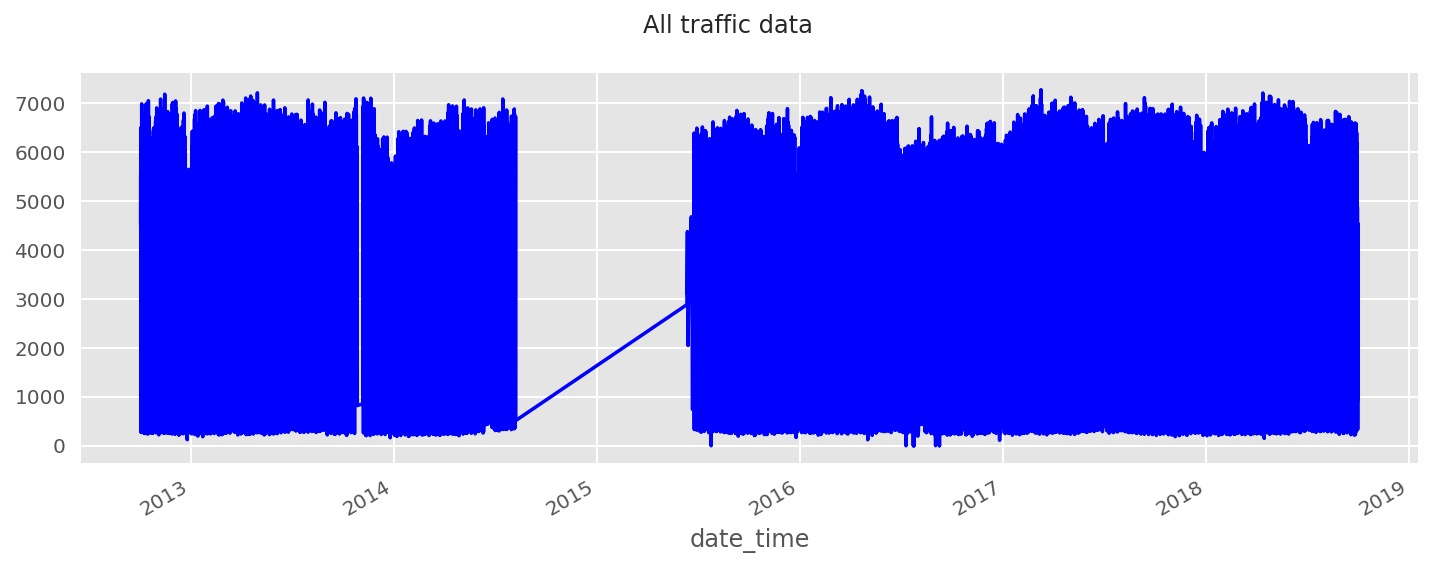

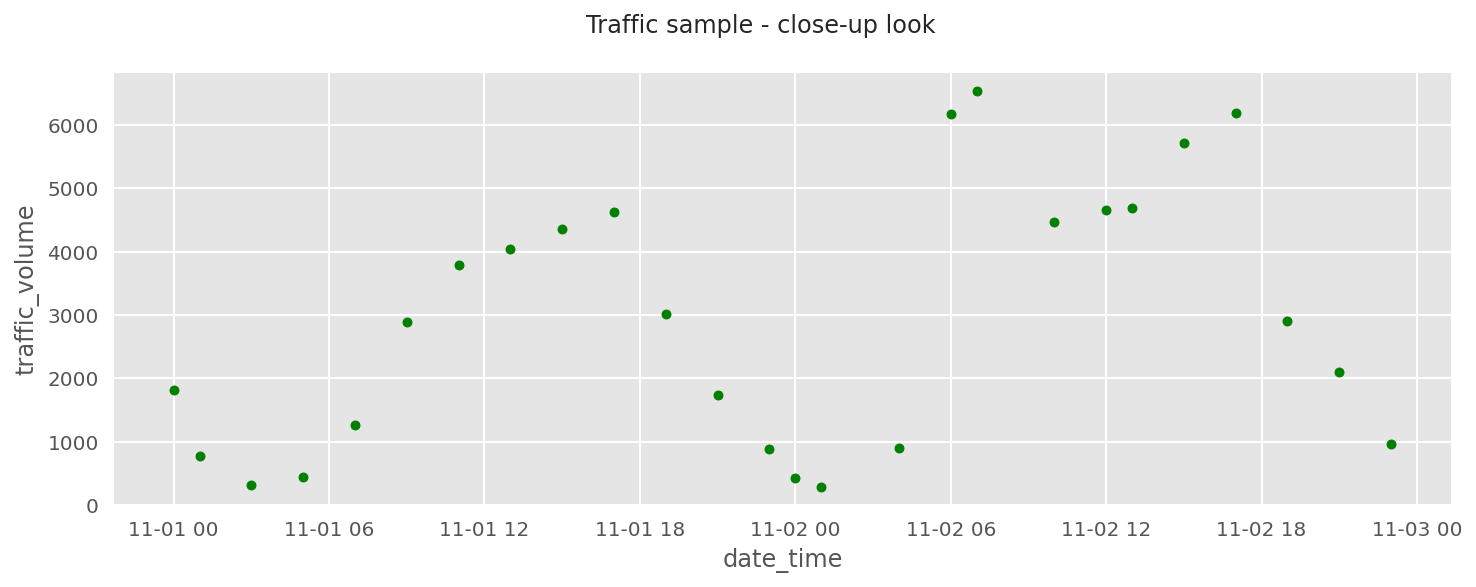

In [9]:
_ = df["traffic_volume"].plot(color='blue')
plt.suptitle("All traffic data")
plt.show()
s0 = df.loc["2015-11-01":"2015-11-02"]
s0.plot.scatter("date_time", "traffic_volume", color="green")
plt.suptitle("Traffic sample - close-up look")
plt.show()

Observations: 
* There is a huge gap in data in 2015;  
* Daily plot shows quite a few missing data.  

We have two alternatives to deal with data in 2015:
* Drop all data before 1 July 2015;
* Join data before 1 July 2014 and after 1 July 2015,   
adjusting the year values in the first part.  

It seems that we have enough contigious data in the 2015-2018 span,   
so we will chose the first, simpler approach.

### Data preprocessing

#### Drop data before 1 July 2015

In [10]:
df = df["2015-07-01":].sort_index()

#### Drop duplicates

In [11]:
df = df[~df.index.duplicated(keep="first")]

#### Add missing DateTimeStamps

In [12]:
idx = pd.date_range(min(df.date_time), max(df.date_time), freq="1H")
df2 = pd.DataFrame(index=idx)
df = df2.join(df, on=df2.index, how="outer")

####  Interpolate data in columns

In [13]:
df["traffic_volume"].interpolate(method="piecewise_polynomial", inplace=True)
df["temp"].interpolate(method="piecewise_polynomial", inplace=True)

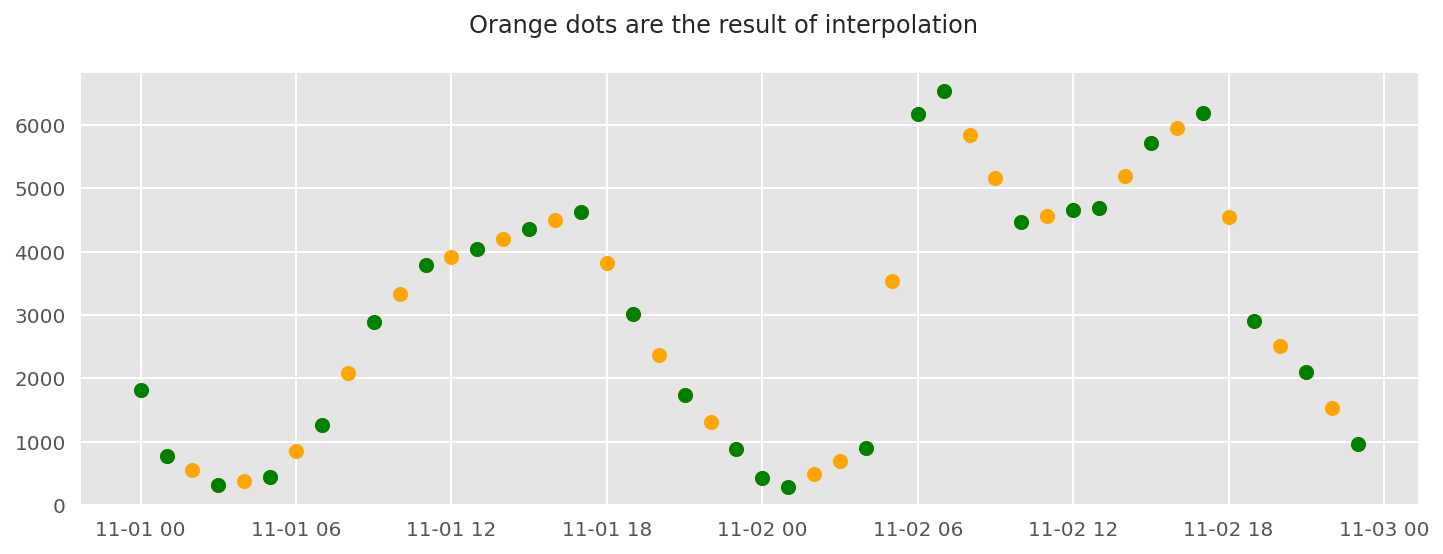

In [14]:
plt.scatter(
    df["2015-11-01":"2015-11-02"].index,
    df.loc["2015-11-01":"2015-11-02"]["traffic_volume"],
    color="orange",
)
plt.scatter(s0.index, s0["traffic_volume"], color="green")
plt.suptitle("Orange dots are the result of interpolation ")
plt.show()

In [15]:
df.head()

,key_0,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
2015-07-01 00:00:00,2015-07-01 00:00:00,None,289.20,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 00:00:00,737.0
2015-07-01 01:00:00,2015-07-01 01:00:00,None,289.40,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 01:00:00,444.0
2015-07-01 02:00:00,2015-07-01 02:00:00,None,289.19,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 02:00:00,347.0
2015-07-01 03:00:00,2015-07-01 03:00:00,None,288.74,0.3,0.0,1.0,Rain,light rain,2015-07-01 03:00:00,356.0
2015-07-01 04:00:00,2015-07-01 04:00:00,None,288.07,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 04:00:00,936.0


#### Inspect resulting dataframe

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2015-07-01 00:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key_0                28512 non-null  datetime64[ns]
 1   holiday              26528 non-null  object        
 2   temp                 28512 non-null  float64       
 3   rain_1h              26528 non-null  float64       
 4   snow_1h              26528 non-null  float64       
 5   clouds_all           26528 non-null  float64       
 6   weather_main         26528 non-null  object        
 7   weather_description  26528 non-null  object        
 8   date_time            26528 non-null  datetime64[ns]
 9   traffic_volume       28512 non-null  float64       
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 3.4+ MB


####  Check holiday values

In [17]:
df["holiday"].value_counts().to_frame()

,holiday
None,26493
Independence Day,4
State Fair,4
Labor Day,4
Columbus Day,3
Veterans Day,3
Thanksgiving Day,3
Christmas Day,3
New Years Day,3
Washingtons Birthday,3


###  Feature engineering

#### Create periodic functions from hour, weekday and month data, add hour, weekday, weekend features, binarize holiday column.

In [18]:
df["weekend"] = (df.index.weekday > 4).astype(int)
df["hour_cos"] = -np.cos(((2 * np.pi * df.index.hour) / 24)) + 1
df["day_sin"] = np.sin(((2 * np.pi * (df.index.weekday) - 1) / 7)) + 1
df["month_cos"] = -np.cos(((2 * np.pi * (df.index.month) / 12))) + 1
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "None" else 1)
df["month"] = df.index.month
df["weekday"] = df.index.weekday
df["hour"] = df.index.hour

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


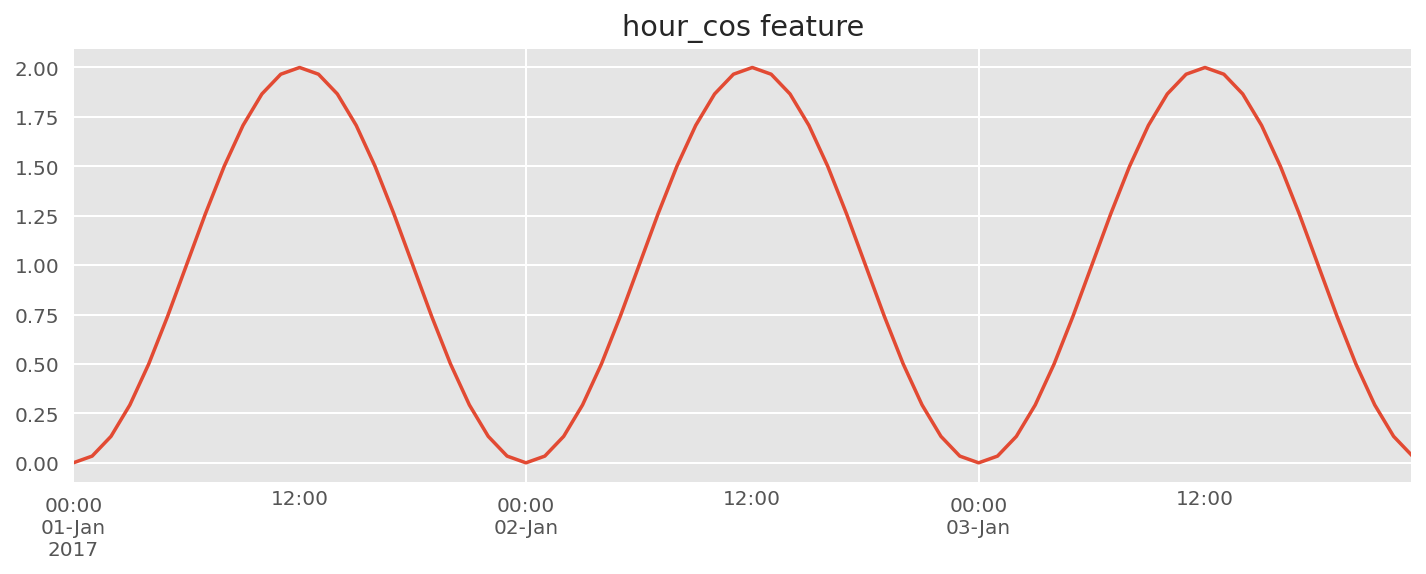

In [19]:
_ = df["2017-01-01":"2017-01-03"]["hour_cos"].plot(title="hour_cos feature")

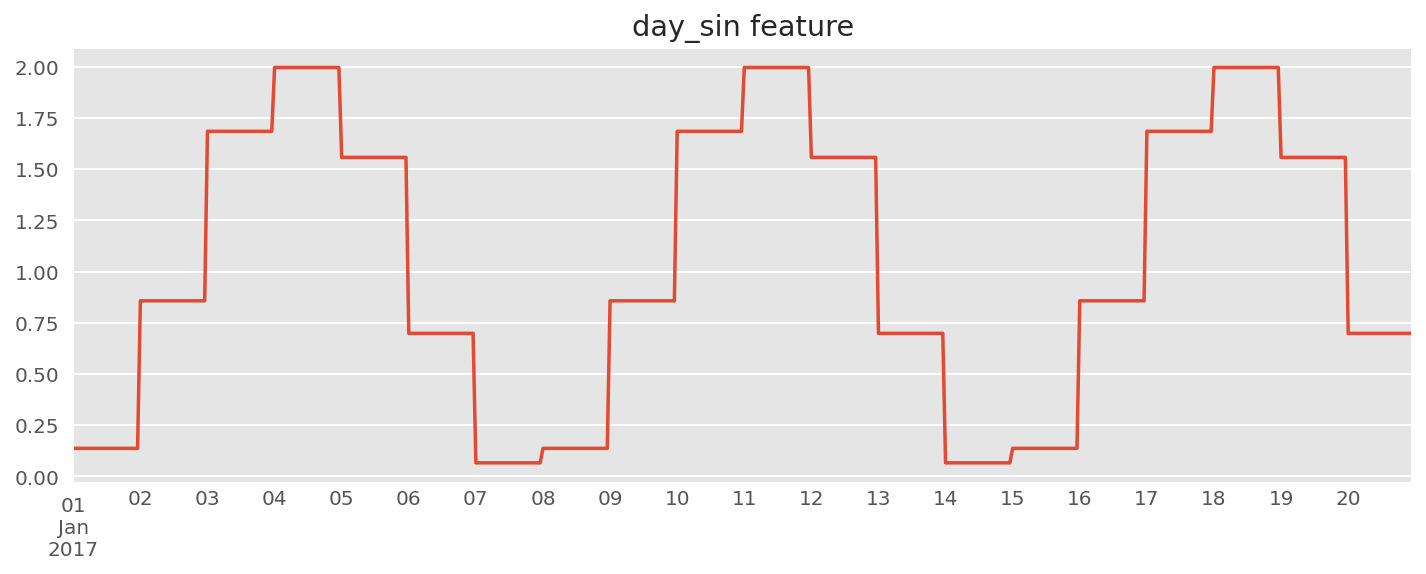

In [20]:
_ = df["2017-01-01":"2017-01-20"]["day_sin"].plot(title="day_sin feature")

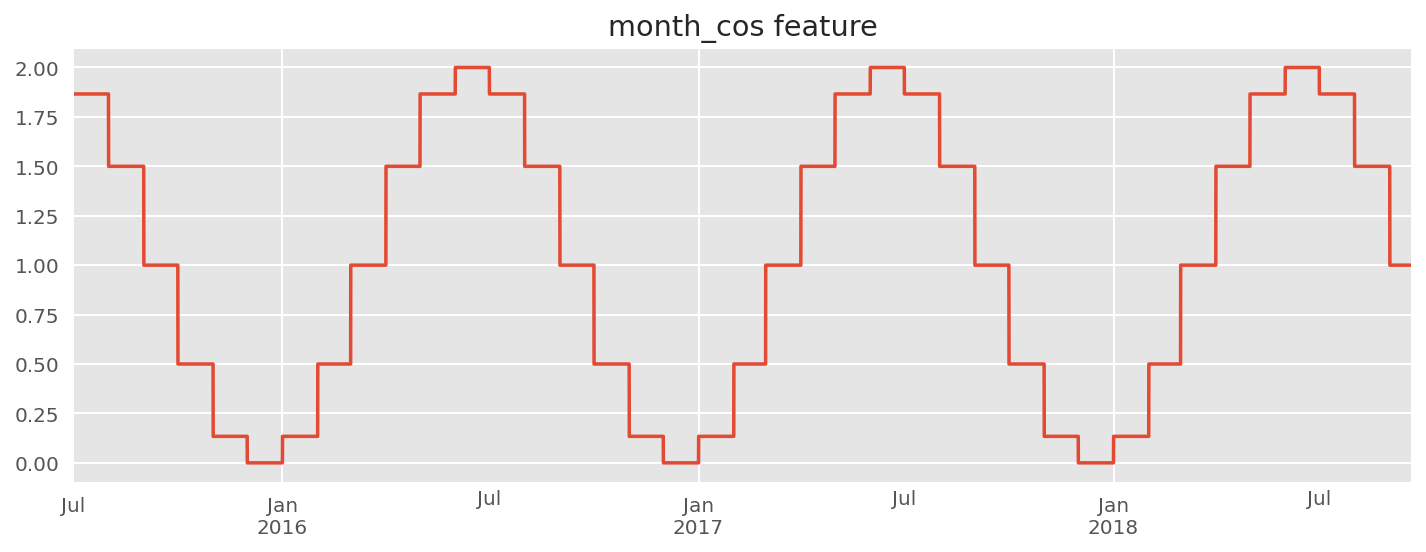

In [21]:
_ = df["2015-07-01":"2018-09-20"]["month_cos"].plot(title="month_cos feature")

In [22]:
df.head()

,key_0,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,weekend,hour_cos,day_sin,month_cos,month,weekday,hour
2015-07-01 00:00:00,2015-07-01 00:00:00,0,289.20,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 00:00:00,737.0,0,0.0000,1.9967,1.866,7,2,0
2015-07-01 01:00:00,2015-07-01 01:00:00,0,289.40,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 01:00:00,444.0,0,0.0341,1.9967,1.866,7,2,1
2015-07-01 02:00:00,2015-07-01 02:00:00,0,289.19,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 02:00:00,347.0,0,0.1340,1.9967,1.866,7,2,2
2015-07-01 03:00:00,2015-07-01 03:00:00,0,288.74,0.3,0.0,1.0,Rain,light rain,2015-07-01 03:00:00,356.0,0,0.2929,1.9967,1.866,7,2,3
2015-07-01 04:00:00,2015-07-01 04:00:00,0,288.07,0.0,0.0,1.0,Clear,sky is clear,2015-07-01 04:00:00,936.0,0,0.5000,1.9967,1.866,7,2,4


#### Drop unneeded columns

In [23]:
df.drop(
    columns=[
        "key_0",
        "rain_1h",
        "snow_1h",
        "clouds_all",
        "weather_main",
        "weather_description",
        "date_time",
    ],
    inplace=True,
)

In [24]:
new_cols = [
    "holiday",
    "weekday",
    "weekend",
    "hour",
    "hour_cos",
    "day_sin",
    "month",
    "month_cos",
    "temp",
    "traffic_volume",
]
df = df[new_cols]
df.head()

,holiday,weekday,weekend,hour,hour_cos,day_sin,month,month_cos,temp,traffic_volume
2015-07-01 00:00:00,0,2,0,0,0.0000,1.9967,7,1.866,289.20,737.0
2015-07-01 01:00:00,0,2,0,1,0.0341,1.9967,7,1.866,289.40,444.0
2015-07-01 02:00:00,0,2,0,2,0.1340,1.9967,7,1.866,289.19,347.0
2015-07-01 03:00:00,0,2,0,3,0.2929,1.9967,7,1.866,288.74,356.0
2015-07-01 04:00:00,0,2,0,4,0.5000,1.9967,7,1.866,288.07,936.0


### Train-test split for baseline model

In [25]:
df_train = df["2017-01-01":"2018-09-23"]
df_test = df["2018-09-24":"2018-09-30"]

###  Baseline model - mean by weekday and hour

In [26]:
yhat_gb = df_train.groupby(["weekday", "hour"])["traffic_volume"].mean()

In [27]:
for ix in df_test.index:
    df_test.loc[ix, "traffic_prediction"] = yhat_gb.loc[
        (df.loc[ix].weekday, df.loc[ix].hour)
    ]
yhat = df_test[-df_test.shape[0] :]["traffic_prediction"]

In [28]:
df_test.tail()

,holiday,weekday,weekend,hour,hour_cos,day_sin,month,month_cos,temp,traffic_volume,traffic_prediction
2018-09-30 19:00:00,0,6,1,19,0.7412,0.1374,9,1.0,283.45,3543.0,3194.4945
2018-09-30 20:00:00,0,6,1,20,0.5000,0.1374,9,1.0,282.76,2781.0,2872.9670
2018-09-30 21:00:00,0,6,1,21,0.2929,0.1374,9,1.0,282.73,2159.0,2434.3956
2018-09-30 22:00:00,0,6,1,22,0.1340,0.1374,9,1.0,282.09,1450.0,1873.3516
2018-09-30 23:00:00,0,6,1,23,0.0341,0.1374,9,1.0,282.12,954.0,1272.9890


#### Baseline model predictions

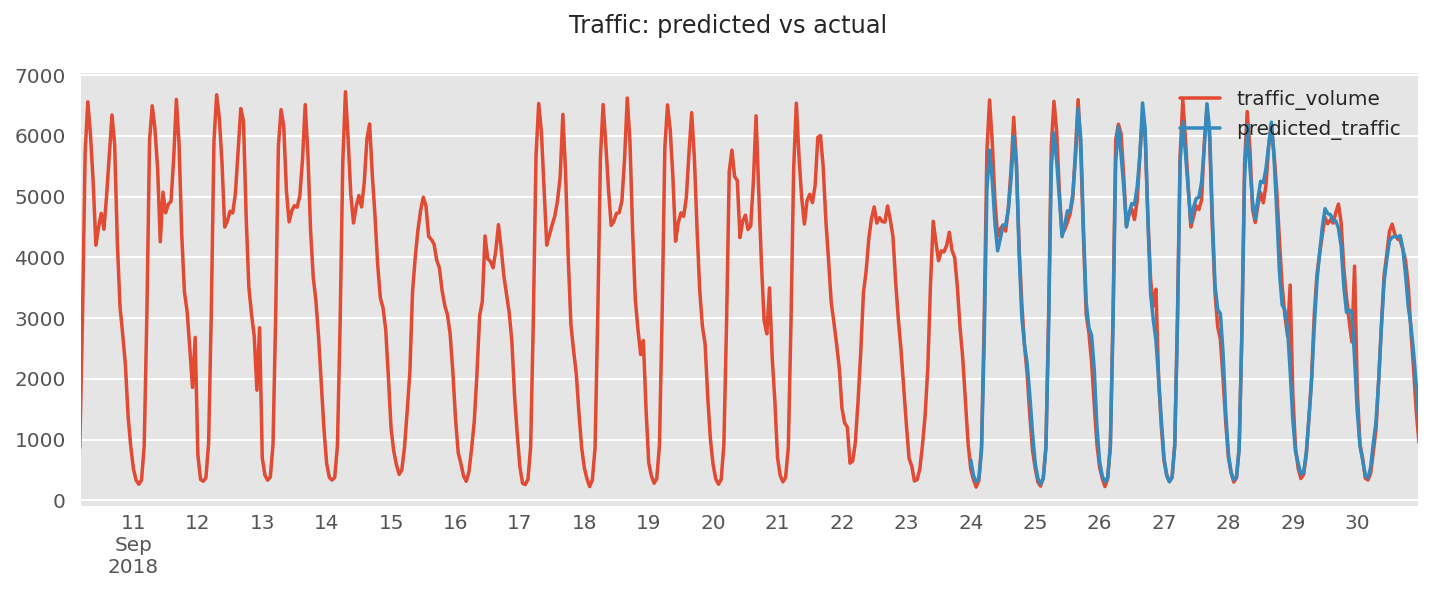

In [29]:
ix_plot = df_train.index.union(df_test.index)
df.loc[ix_plot[-500:]][["traffic_volume"]].plot()
yhat.plot(label="predicted_traffic")
plt.suptitle("Traffic: predicted vs actual")
plt.legend(loc="upper right")
plt.show()

#### RMSE metrics of baseline model

In [30]:
print(f"Base model MAE = {mae(df_test['traffic_volume'], yhat):.1f}")
print(f"Base model RMSE = {np.sqrt(mse(df_test['traffic_volume'], yhat)):.1f}")

Base model MAE = 183.8
Base model RMSE = 280.6


###  Pycaret regression

In [31]:
df1 = df.copy()
df1["traffic_volume"] = df1["traffic_volume"] + 1
df1.tail()

,holiday,weekday,weekend,hour,hour_cos,day_sin,month,month_cos,temp,traffic_volume
2018-09-30 19:00:00,0,6,1,19,0.7412,0.1374,9,1.0,283.45,3544.0
2018-09-30 20:00:00,0,6,1,20,0.5000,0.1374,9,1.0,282.76,2782.0
2018-09-30 21:00:00,0,6,1,21,0.2929,0.1374,9,1.0,282.73,2160.0
2018-09-30 22:00:00,0,6,1,22,0.1340,0.1374,9,1.0,282.09,1451.0
2018-09-30 23:00:00,0,6,1,23,0.0341,0.1374,9,1.0,282.12,955.0


#### Train-test split for Pycaret models

#### Choose between using only "traffic_volume" and all features

##### Use only "traffic_volume"

In [32]:
# df1.drop(
#     columns=[
#         "holiday",
#         "weekday",
#         "weekend",
#         "hour",
#         "hour_cos",
#         "day_sin",
#         "month",
#         "month_cos",
#         "temp",
#     ],
#     inplace=True,
# )

##### Use all features

In [33]:
df1.drop(
    columns=[
        "hour",
        "month"
    ],
    inplace=True,
)

In [34]:
data = df1["2017-01-01":"2018-09-30"]

In [35]:
data.tail()

,holiday,weekday,weekend,hour_cos,day_sin,month_cos,temp,traffic_volume
2018-09-30 19:00:00,0,6,1,0.7412,0.1374,1.0,283.45,3544.0
2018-09-30 20:00:00,0,6,1,0.5000,0.1374,1.0,282.76,2782.0
2018-09-30 21:00:00,0,6,1,0.2929,0.1374,1.0,282.73,2160.0
2018-09-30 22:00:00,0,6,1,0.1340,0.1374,1.0,282.09,1451.0
2018-09-30 23:00:00,0,6,1,0.0341,0.1374,1.0,282.12,955.0


##### Last week is left for predictions by Pycaret (fh = 24*7)

In [36]:
s = setup(
    data=data,
    target="traffic_volume",
    enforce_exogenous=True,
    fold=5,
    fh=24*7,
    seasonal_period=24*7,
    session_id=random_state,
)

,Description,Value
0,session_id,17
1,Target,traffic_volume
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(15312, 8)"
5,Train data shape,"(15144, 8)"
6,Test data shape,"(168, 8)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,5
9,Enforce Prediction Interval,False


#### Explore data properties in Pycaret

In [37]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Actual,Length,,15312.0
1,Summary,Statistics,Actual,Mean,,3351.5635
2,Summary,Statistics,Actual,Median,,3546.5
3,Summary,Statistics,Actual,Standard Deviation,,1979.1444
4,Summary,Statistics,Actual,Variance,,3917012.5234
5,Summary,Statistics,Actual,Kurtosis,,-1.2792
6,Summary,Statistics,Actual,Skewness,,-0.1564
7,Summary,Statistics,Actual,# Distinct Values,,5682.0
8,White Noise,Ljung-Box,Actual,Test Statictic,"{'alpha': 0.05, 'K': 24}",91231.0813
9,White Noise,Ljung-Box,Actual,Test Statictic,"{'alpha': 0.05, 'K': 48}",171664.4196


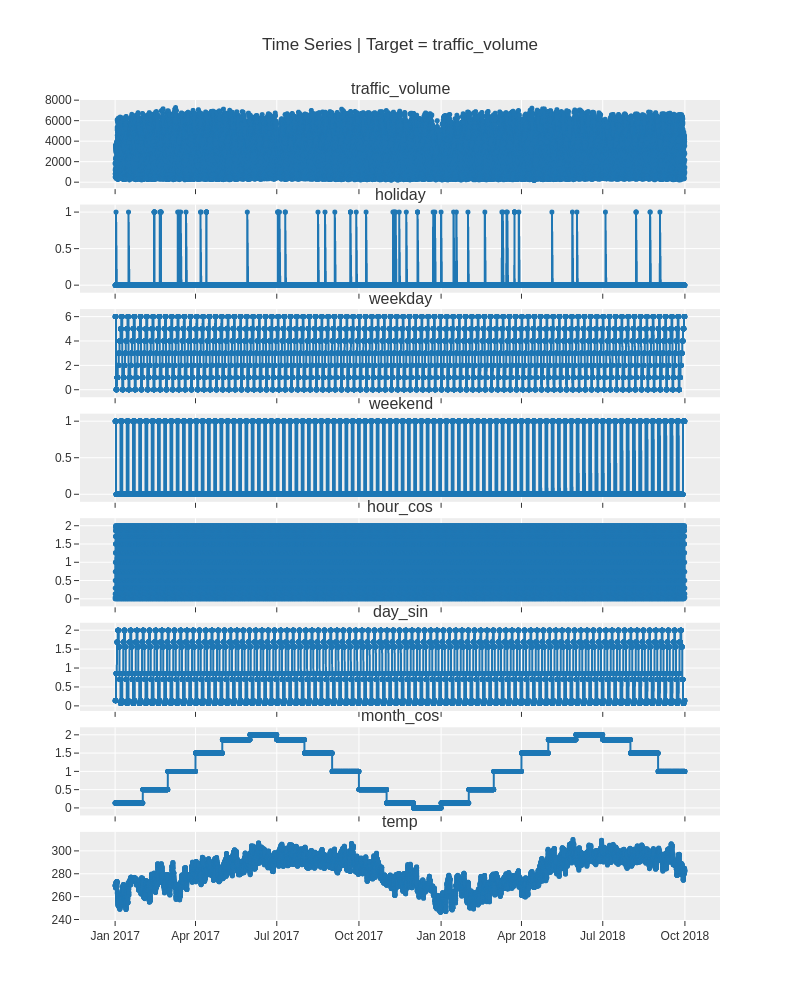

In [38]:
plot_model(plot = 'ts', fig_kwargs={"height": 1000, "width": 800})

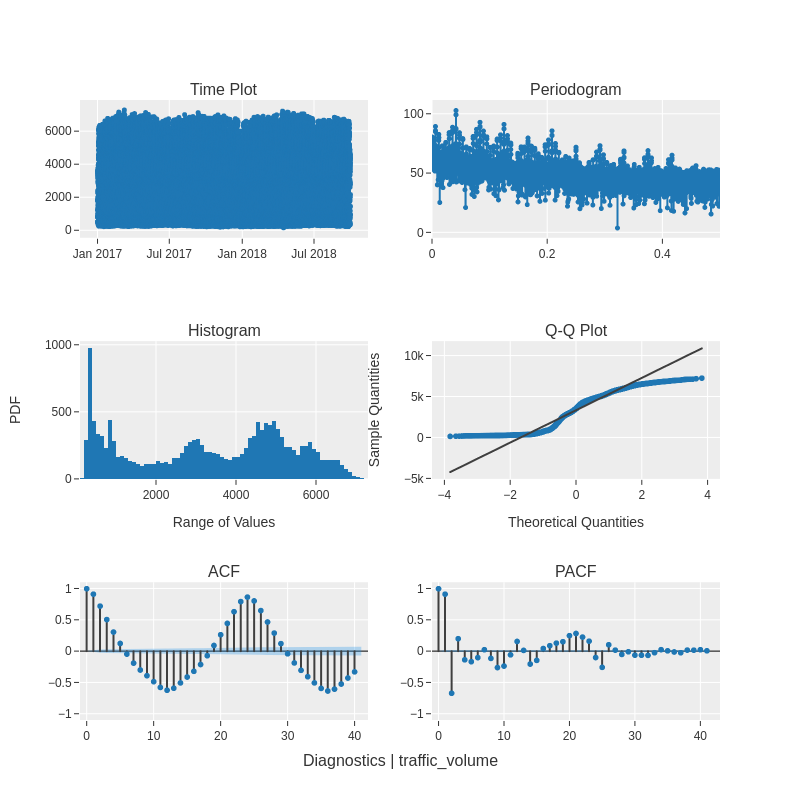

In [39]:
plot_model(plot='diagnostics', fig_kwargs={"height": 800, "width": 800})

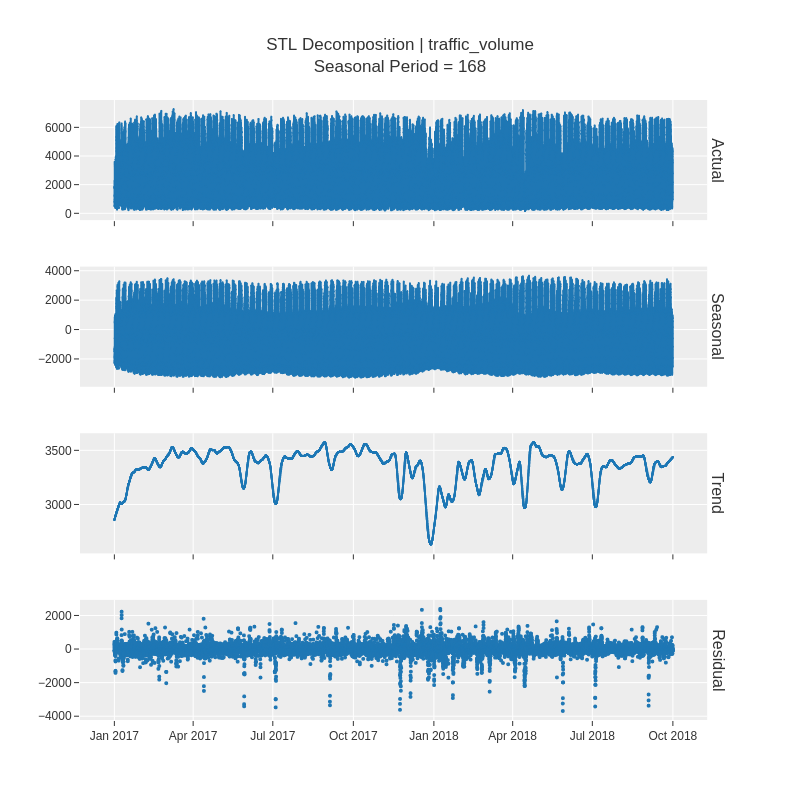

In [40]:
plot_model(plot = 'decomp_stl', fig_kwargs ={"height": 800, "width": 800})

#### Use only fast and more accurate models after preselection

In [41]:
select_models = [
    "lasso_cds_dt",
    "br_cds_dt",
    "huber_cds_dt",
    "omp_cds_dt",
#     "catboost_cds_dt"
]

In [42]:
best3 = compare_models(
    include=select_models,
    sort="MAE",
    verbose=1,
    n_select=3
)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,220.5781,353.2896,0.0993,0.0871,0.6839,0.5798,0.9580,3.2720
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,220.6086,347.1310,0.1078,0.0928,0.6839,0.5697,0.9590,10.6040
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,222.5394,347.3160,0.1071,0.0923,0.6899,0.5699,0.9599,0.8420
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,223.9685,352.3122,0.1081,0.0929,0.6943,0.5782,0.9580,3.2060


In [43]:
print(best3)

[BaseCdsDtForecaster(regressor=HuberRegressor(), sp=168, window_length=168), BaseCdsDtForecaster(regressor=Lasso(random_state=17), sp=168, window_length=168), BaseCdsDtForecaster(regressor=OrthogonalMatchingPursuit(), sp=168,
                    window_length=168)]


### Blend 3 top models to make final model more stable

In [44]:
blender = blend_models(best3)

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-08-19 23:00,181.2669,245.3469,0.1107,0.0950,0.5586,0.4005,0.9845
1,2018-08-26 23:00,154.6451,202.0783,0.0546,0.0546,0.4785,0.3313,0.9900
2,2018-09-02 23:00,350.1800,698.7590,0.1877,0.1317,1.0894,1.1513,0.8670
3,2018-09-09 23:00,208.2085,310.4307,0.0722,0.0753,0.6461,0.5094,0.9756
4,2018-09-16 23:00,203.0981,281.9307,0.0894,0.0886,0.6295,0.4608,0.9788
Mean,NaT,219.4797,347.7091,0.1029,0.0890,0.6804,0.5707,0.9592
SD,NaT,68.0319,179.2422,0.0463,0.0254,0.2129,0.2964,0.0463


In [45]:
predictions = predict_model(blender)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,EnsembleForecaster,162.8396,263.4158,0.0713,0.0715,0.5067,0.4322,0.9824


##### Plot predictions

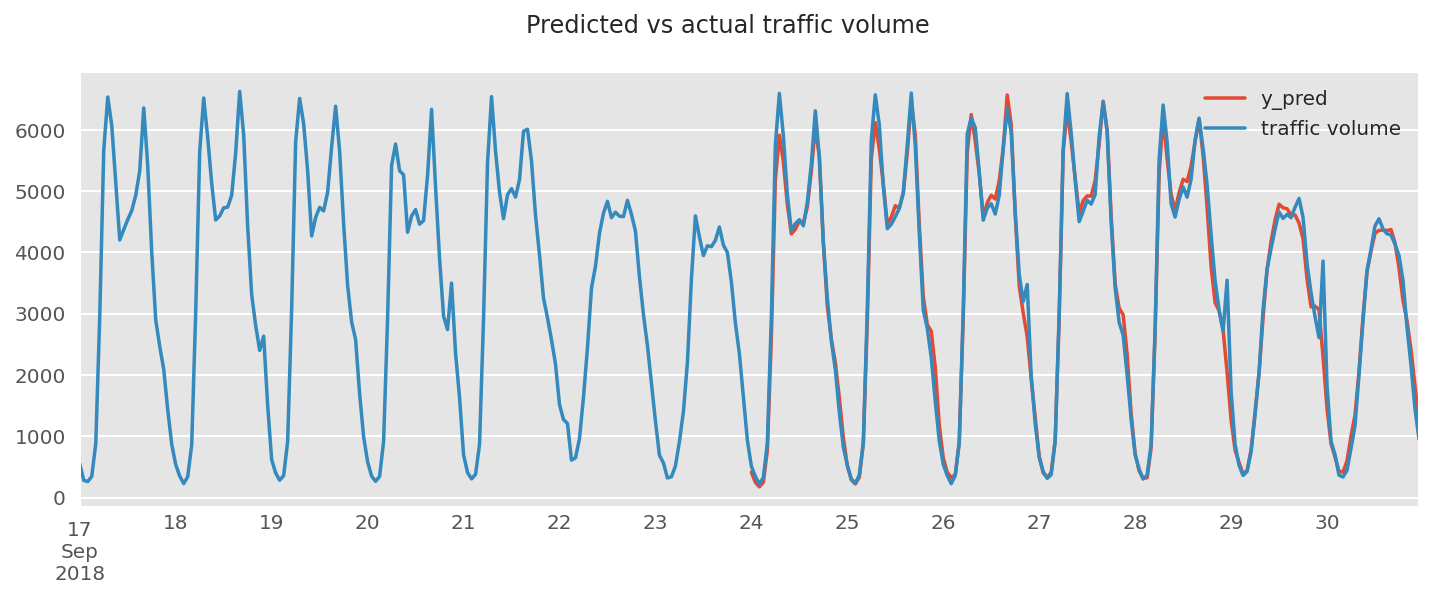

In [46]:
predictions.plot(label="traffic_predicted")
data[-24*7*2:]['traffic_volume'].plot(label="traffic volume")
plt.suptitle("Predicted vs actual traffic volume")
plt.legend()
plt.show()

##### Save model

In [47]:
save_model(blender, 'saved_blender_model')

Transformation Pipeline and Model Successfully Saved


(_EnsembleForecasterWithVoting(forecasters=[('HuberRegressor',
                                             BaseCdsDtForecaster(regressor=HuberRegressor(),
                                                                 sp=168,
                                                                 window_length=168)),
                                            ('Lasso',
                                             BaseCdsDtForecaster(regressor=Lasso(random_state=17),
                                                                 sp=168,
                                                                 window_length=168)),
                                            ('OrthogonalMatchingPursuit',
                                             BaseCdsDtForecaster(regressor=OrthogonalMatchingPursuit(),
                                                                 sp=168,
                                                                 window_length=168))],
                               n_jo

### Arima model

#### Arima is very resourse-hungry, need to make train size smaller

In [48]:
data2 = df1["2018-06-01":"2018-09-30"] #

#### Model setup

In [49]:
a = setup(
    data=data2,
    target="traffic_volume",
    enforce_exogenous=True,
    fold=3,
    fh=24*7,
    seasonal_period=24*7,
    session_id=random_state,
)

,Description,Value
0,session_id,17
1,Target,traffic_volume
2,Approach,Univariate
3,Exogenous Variables,Present
4,Data shape,"(2928, 8)"
5,Train data shape,"(2760, 8)"
6,Test data shape,"(168, 8)"
7,Fold Generator,ExpandingWindowSplitter
8,Fold Number,3
9,Enforce Prediction Interval,False


In [50]:
arima = create_model('arima')

,cutoff,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,2018-09-02 23:00,361.3078,759.4012,0.2014,0.1475,1.5200,1.5928,0.8429
1,2018-09-09 23:00,352.3828,815.4526,0.1150,0.1407,1.4135,1.6079,0.8317
2,2018-09-16 23:00,215.2230,339.8531,0.0995,0.0953,0.8392,0.6383,0.9692
Mean,NaT,309.6379,638.2356,0.1386,0.1278,1.2576,1.2797,0.8813
SD,NaT,66.8607,212.2256,0.0448,0.0232,0.2990,0.4536,0.0624


#### Model predictions

In [51]:
predict_arima = predict_model(arima, return_pred_int=True)

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2
0,ARIMA,201.2006,329.9344,0.0974,0.0929,0.7939,0.6321,0.9724


#### Plot results with prediction intervals

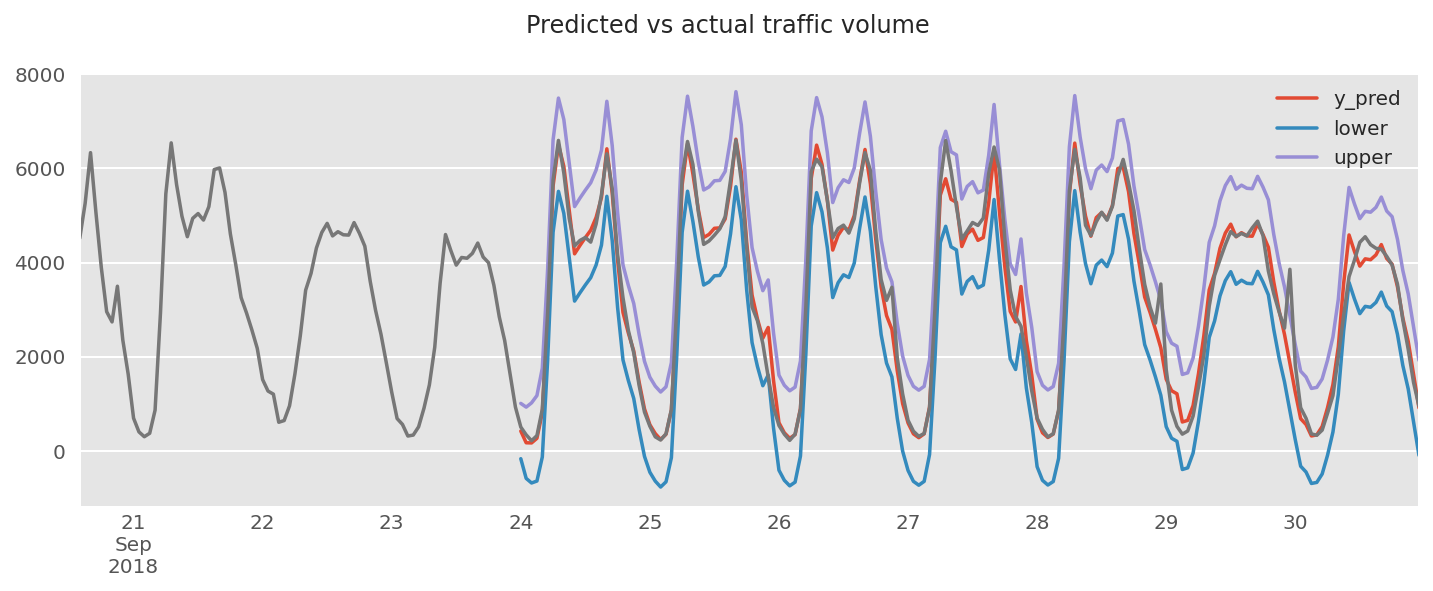

In [52]:
predict_arima[['y_pred','lower','upper']].plot() 
data[-250:]['traffic_volume'].plot(label="traffic volume") 
plt.suptitle("Predicted vs actual traffic volume")
plt.legend()
plt.show()

#### Save model

In [53]:
save_model(arima, 'saved_arima_model')

Transformation Pipeline and Model Successfully Saved


(ARIMA(seasonal_order=(0, 1, 0, 168)), 'saved_arima_model.pkl')

### CONCLUSION

Time series models included with Pycaret failed to beat baseline model, but the library is fun to work with. Note that vanilla arima gets better results even on a smaller train dataset. When you need to explore data and build model fast, this is a library of choice.